# Natural Language Processing - Bill Text Exploration

**This analysis includes combined text of bill titles and summaries**

Transform the raw data into feature vectors and these new features will be created using the existing dataset. Structure as follows:

Data Exploration
- Word Cloud 

Vectorizers
- Custom and Spacy Tokenizer
- Count Vectors as features
- TF-IDF Vectors as features

- Word level
- N-Gram level

Character level
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [117]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


In [118]:
from sodapy import Socrata
import sqlalchemy as db

import config_final as config
from schema import DbSchema



In [119]:
bills_db = DbSchema(config)


In [120]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [121]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [122]:
df = query('SELECT * FROM con_bills.current_bills WHERE Cong >= 110')


In [123]:
df.shape

(51067, 29)

In [124]:
df.tail()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PassH,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary
51062,114-S-995,s,1,114,1.0,2015-04-16 00:00:00,0,0,A bill to establish congressional trade negoti...,0,...,0,0,None,0,1,1,18.0,1802.0,https://www.congress.gov/bill/114th-congress/s...,Bipartisan Congressional Trade Priorities and ...
51063,114-S-996,s,1,114,7.0,2015-04-16 00:00:00,0,0,A bill to facilitate nationwide availability o...,0,...,0,0,None,0,1,0,13.0,1302.0,https://www.congress.gov/bill/114th-congress/s...,Volunteer Income Tax Assistance (VITA) Act
51064,114-S-997,s,1,114,1.0,2015-04-16 00:00:00,0,0,A bill to extend the authorization for the maj...,0,...,0,0,None,0,1,1,3.0,322.0,https://www.congress.gov/bill/114th-congress/s...,"Department of Veterans Affairs Construction, A..."
51065,114-S-998,s,1,114,4.0,2015-04-16 00:00:00,0,0,A bill to establish a process for the consider...,0,...,0,0,None,0,1,1,18.0,1807.0,https://www.congress.gov/bill/114th-congress/s...,American Manufacturing Competitiveness Act of ...
51066,114-S-999,s,1,114,0.0,2015-04-16 00:00:00,0,0,A bill to amend the Small Business Act to prov...,0,...,0,0,None,0,1,1,15.0,1521.0,https://www.congress.gov/bill/114th-congress/s...,Small Business Development Centers Improvement...


**Final Cleaning:**

In [125]:
df['Summary'].isnull().sum()

50

In [126]:
df['Summary'].fillna('None', inplace = True)

In [127]:
df['Summary'].isnull().sum()

0

In [128]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [129]:
# blanks = []

# for i, billID, title, summary, PassH, Cong in df.itertuples():  # iterate over the DataFrame
#     if type(summary)==str:            # avoid NaN values
#         if summary.isspace():         # test 'plot' for whitespace
#             blanks.append(i)
                  
# len(blanks)

In [130]:
df.shape

(51067, 29)

**Combine Title and Summary columns:**

In [131]:
df['combined_text'] = df[['Title', 'Summary']].astype(str).apply(' '.join, axis=1)

In [132]:
# df_combined_text = df['combined_text', 'PassH']

In [133]:
import pickle
#is it vectorizer or transformed?
com_text = 'combined_text_2.sav'
pickle.dump(df_combined_text, open(com_text, 'wb'))
 

In [134]:
df.isnull().sum()

BillID               0
BillType             0
Chamber              0
Cong                 0
Cosponsr             0
IntrDate            42
Mult                 0
PLaw                 0
Title                0
Veto                 0
Class                0
District             0
FrstConH             0
FrstConS             0
Gender               0
MRef                 0
NameFull             0
Party                0
Postal               0
PassH                0
PassS                0
PLawDate         49674
PLawNum              0
ImpBill              0
Majority             0
Major                0
Minor                0
URL                  0
Summary              0
combined_text        0
dtype: int64

In [135]:
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


# Topic Modeling

**Split Training and Testing Data**

In [136]:
from sklearn import preprocessing

In [137]:
from sklearn.model_selection import train_test_split

X = df['combined_text']
y = df['PassH']

X_train, X_test, y_train1, y_test1 = train_test_split(X, y, random_state=2)

Encode our target column so that it can be used in machine learning models (may not be necessary since the data is already binary)

## Feature Engineering


**Cleaning Text**

Test both the spacy tokenizer and personalized tokenizer against the data.

In [101]:
import spacy
from spacy.lang.en import English
# For part of speech tagging
import en_core_web_sm

nlp = English()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal", "provide"}


In [102]:
#Define the spacy tokenizer
spacy_tokenizer = spacy.load('en_core_web_sm', disable =['tagger', 'parser', 'ner'])

In [103]:
import string
import re

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')


<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-103-983721234798>:4: DeprecationWarning: invalid escape sequence \[
  replace_with_space = re.compile('[/(){}\[\]\|@,;]')
<ipython-input-103-983721234798>:6: DeprecationWarning: invalid escape sequence \s
  just_words = re.compile('[^a-zA-Z\s]')


In [104]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

In [105]:
test_fun = df.iloc[3586][29]
test_fun

'To accelerate the reduction of greenhouse gas emissions in the United States by establishing a market-driven system of greenhouse gas tradeable allowances that will limit greenhouse gas emissions in the United States, reduce dependence upon foreign oil, and ensure benefits to consumers from the trading in such allowances, and for other purposes. Climate Stewardship and Economic Security Act of 2007 - Requires the Administrator of the Environmental Protection Agency (EPA) to establish a National Greenhouse Gas Database consisting of: (1) an inventory of greenhouse gas (GHG) emissions by covered entities (specified entities that own or control a source of GHG emissions in the electric power, industrial, and commercial sectors of the U.S. economy that emit more than 10,000 metric tons of GHGs per year); and (2) a registry of GHG emission reductions and increased sequestration, applicable to all entities.'

In [106]:
tokenizer(test_fun)


['accelerate',
 'reduction',
 'greenhouse',
 'gas',
 'emission',
 'establish',
 'marketdriven',
 'system',
 'greenhouse',
 'gas',
 'tradeable',
 'allowance',
 'limit',
 'greenhouse',
 'gas',
 'emission',
 'reduce',
 'dependence',
 'foreign',
 'oil',
 'ensure',
 'benefit',
 'consumer',
 'trading',
 'allowance',
 'climate',
 'stewardship',
 'economic',
 'security',
 'require',
 'administrator',
 'environmental',
 'protection',
 'agency',
 'epa',
 'establish',
 'national',
 'greenhouse',
 'gas',
 'database',
 'consist',
 'inventory',
 'greenhouse',
 'gas',
 'ghg',
 'emission',
 'covered',
 'entity',
 'specify',
 'entity',
 'control',
 'source',
 'ghg',
 'emission',
 'electric',
 'power',
 'industrial',
 'commercial',
 'sector',
 'economy',
 'emit',
 'metric',
 'ton',
 'ghg',
 'year',
 'registry',
 'ghg',
 'emission',
 'reduction',
 'increase',
 'sequestration',
 'applicable',
 'entity']

**CountVectorizer**

Every row represents a document in the corpus, every column represents a term in the document, every cell represents the frequency count of a particular term in a particular document.

Tuning: analyzer, vectorizer, max_features, max_df, min_df, n_grams

Explore:

min_df:

- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".

max_df: Attempt to remove heavily used words.

- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".

In [107]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, max_features = 10000) # max_df=0.90, min_df=10


In [108]:
type(vectorizer)

sklearn.feature_extraction.text.CountVectorizer

In [109]:
import pickle
#is it vectorizer or transformed?
filename1 = 'finalized_vectorizer.sav'
pickle.dump(vectorizer, open(filename1, 'wb'))
 

In [ ]:
transformed = vectorizer.fit_transform(X, y)
print(len(vectorizer.get_feature_names()))

In [111]:

#is it vectorizer or transformed?
filename = 'finalized_countvectorizer_model.sav'
pickle.dump(transformed, open(filename, 'wb'))
 

OPEN THE PICKLES

In [142]:
# load the model from disk
transformed_pk = pickle.load(open('finalized_countvectorizer_model.sav', 'rb'))

transformed_pk
# result = loaded_model.score(X_test, Y_test)
# print(result)

<51067x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 1245842 stored elements in Compressed Sparse Row format>

In [143]:
vectorized_pk = pickle.load(open('finalized_vectorizer.sav', 'rb'))

vectorized_pk

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer at 0x1a31b25400>,
                vocabulary=None)

**Exploring Stored Words**

Think about the number of words and how to decrease that list!

Lemmatization should be something to further consider, also limiting specific words (pronouns?) used often

In [113]:
len(vectorizer.get_feature_names())

10000

In [114]:
import random

#get ten random words from each

for i in range(10):
    word_id = random.randint(0, 2454) #second should be len of cv
    print(vectorizer.get_feature_names()[word_id])

agent
collins
arab
abroad
complie
audits
booker
defund
awareness
coltsville


**Topic - Modeling LDA**


LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [115]:
from sklearn.decomposition import LatentDirichletAllocation

**OPTIONAL - Grisearch LDA**

In [116]:
# from sklearn.model_selection import GridSearchCV


# # Define Search Param
# search_params = {'n_components': [13],
#                  'learning_decay': [.3],
#                  'random_state': [2]
#                 }

# # Init the Model
# lda = LatentDirichletAllocation()

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=2, n_jobs = -1)

# # Do the Grid Search
# model.fit(loaded_model)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.5min finished


KeyboardInterrupt: 

In [153]:
# # Best Model
# best_lda_model_1 = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)

# # Perplexity
# print("Model Perplexity: ", best_lda_model.perplexity(transformed))

# #Shows best params
# #shows best log likelihood
# #shows model perplexity score

In [ ]:
filename2 = 'finalized_lda_model.sav'
pickle.dump(best_lda_model_1, open(filename2, 'wb'))
 

In [144]:
# load the model from disk
best_lda_model = pickle.load(open('finalized_lda_model.sav', 'rb'))

best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.3,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=13, n_jobs=None,
                          perp_tol=0.1, random_state=2, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [145]:
best_lda_model.components_

array([[7.69248361e-02, 1.33196783e-01, 7.69246040e-02, ...,
        8.39427504e+00, 7.69230769e-02, 7.69237492e-02],
       [7.69231841e-02, 2.00867833e+00, 7.69231627e-02, ...,
        7.69238571e-02, 7.69278536e-02, 7.69230769e-02],
       [7.69234439e-02, 7.69233542e-02, 7.69231652e-02, ...,
        7.69233910e-02, 1.00769227e+01, 7.69230769e-02],
       ...,
       [1.20769153e+01, 1.12520009e+01, 7.69231237e-02, ...,
        2.56766288e-01, 7.69232750e-02, 7.69230769e-02],
       [7.69230769e-02, 5.90472955e+01, 7.69243560e-02, ...,
        2.58180257e+02, 7.69289197e-02, 7.69241609e-02],
       [7.69230769e-02, 7.69233664e-02, 7.69255997e-02, ...,
        7.69234406e-02, 7.69233618e-02, 7.69230769e-02]])

**Model evaluation:**

Look at model components:

In [146]:
best_lda_model.components_

array([[7.69248361e-02, 1.33196783e-01, 7.69246040e-02, ...,
        8.39427504e+00, 7.69230769e-02, 7.69237492e-02],
       [7.69231841e-02, 2.00867833e+00, 7.69231627e-02, ...,
        7.69238571e-02, 7.69278536e-02, 7.69230769e-02],
       [7.69234439e-02, 7.69233542e-02, 7.69231652e-02, ...,
        7.69233910e-02, 1.00769227e+01, 7.69230769e-02],
       ...,
       [1.20769153e+01, 1.12520009e+01, 7.69231237e-02, ...,
        2.56766288e-01, 7.69232750e-02, 7.69230769e-02],
       [7.69230769e-02, 5.90472955e+01, 7.69243560e-02, ...,
        2.58180257e+02, 7.69289197e-02, 7.69241609e-02],
       [7.69230769e-02, 7.69233664e-02, 7.69255997e-02, ...,
        7.69234406e-02, 7.69233618e-02, 7.69230769e-02]])

In [148]:
single_topic = best_lda_model.components_[0]

In [149]:
# Returns the indices that would sort this array.
single_topic.argsort()

#look at the most and least representative words!

array([6485, 1468, 7860, ..., 7160, 8140, 5060])

In [150]:
# Word least representative of this topic
single_topic[1279]


0.9787192149504518

In [151]:
# Word most representative of this topic
single_topic[7710]

0.07692820933168064

Look at the top fifteen for each topic:

In [152]:
for index,topic in enumerate(best_lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#print top fifteen words for each topic
#increase number of topics to get more specific topics
#go back and clean some of the data based on answers

THE TOP 15 WORDS FOR TOPIC #0
['information', 'employee', 'certain', 'code', 'right', 'foreign', 'immigration', 'homeland', 'require', 'criminal', 'enforcement', 'person', 'prohibit', 'security', 'law']


THE TOP 15 WORDS FOR TOPIC #1
['exchange', 'establish', 'use', 'production', 'require', 'security', 'renewable', 'policy', 'commission', 'oil', 'fuel', 'gas', 'product', 'consumer', 'energy']


THE TOP 15 WORDS FOR TOPIC #2
['family', 'title', 'va', 'affair', 'facility', 'health', 'affairs', 'service', 'medical', 'child', 'veteran', 'program', 'department', 'veterans', 'care']


THE TOP 15 WORDS FOR TOPIC #3
['amends', 'hospital', 'benefit', 'insurance', 'medicaid', 'payment', 'service', 'xviii', 'program', 'small', 'business', 'medicare', 'title', 'social', 'security']


THE TOP 15 WORDS FOR TOPIC #4
['require', 'war', 'benefit', 'employee', 'compensation', 'title', 'code', 'defense', 'pay', 'armed', 'veteran', 'military', 'service', 'force', 'member']


THE TOP 15 WORDS FOR TOPIC #5

In [ ]:
# # Create Document - Topic Matrix
# lda_output = best_lda_model.transform(transformed)

# # column names
# topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# # index names
# docnames = ["Doc" + str(i) for i in range(len(X_train))]

# # Make the pandas dataframe
# df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# # Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

# # Styling
# def color_green(val):
#     color = 'green' if val > .1 else 'black'
#     return 'color: {col}'.format(col=color)

# def make_bold(val):
#     weight = 700 if val > .1 else 400
#     return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
# df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
# df_document_topics

# #final column shows the topic each document is most 'like'
# #topcis are distribution of words, and see which scores most highly on, and applying that topic to the document

In [154]:
#Add output to the dataframe:

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# index names
docnames = ["Doc" + str(i) for i in range(len(X))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=df['BillID'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
BillID,,,,,,,,,,,,,,
110-HR-1,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5
110-HR-10,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,0.36,0.03,0.03,10
110-HR-100,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,0.35,0.00,0.00,4
110-HR-1000,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.84,0.00,0.08,10
110-HR-1001,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,0.00,0.04,0.00,5


In [155]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
BillID,,,,,,,,,,,,,,
110-HR-1,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5
110-HR-10,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,0.36,0.03,0.03,10
110-HR-100,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,0.35,0.00,0.00,4
110-HR-1000,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.84,0.00,0.08,10
110-HR-1001,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,0.00,0.04,0.00,5


In [156]:
df_document_topic.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [157]:
test = pd.concat([df_document_topic, df], axis=1)

In [158]:
test.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,...,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,...,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,...,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,...,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,...,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


Text(0.5, 1.0, 'Bill Topic Percentage Proposals by Congress')

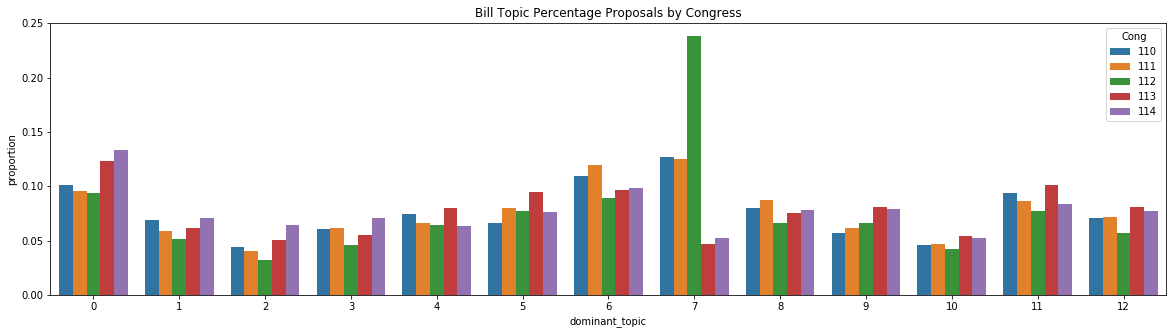

In [159]:
#Looking at dominant topic contribution by proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x1, y1, hue = "dominant_topic", "proportion", "Cong"
hue_order = ["1", "0"]
data=test

(test[x1]
 .groupby(test[hue])
 .value_counts(normalize=True)
 .rename(y1)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x1, y=y1, hue=hue).set_title('Bill Topic Percentage Proposals by Congress'))


In [160]:
test['dominant_topic'].head()

0     5
1    10
2     4
3    10
4     5
Name: dominant_topic, dtype: int64

Text(0.5, 1.0, 'Topic by Percent Contribution to Passage')

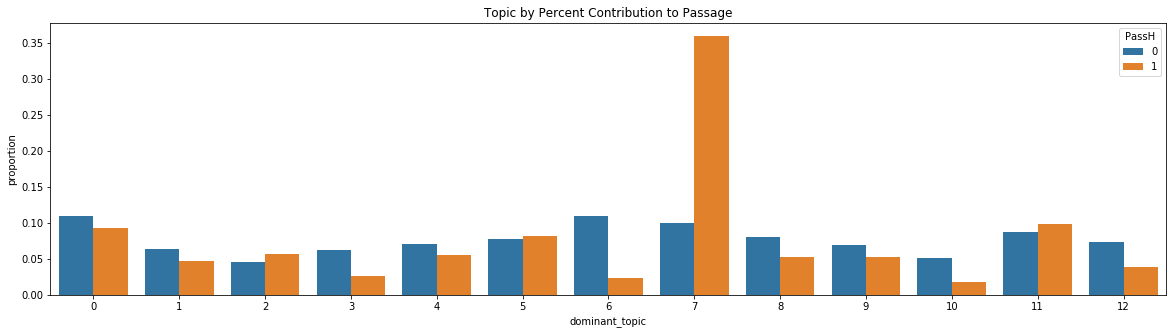

In [161]:
#Looking at dominant topic contribution by proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x2, y2, hue = "dominant_topic", "proportion", "PassH"
hue_order = ["1", "0"]
data=test

(test[x2]
 .groupby(test[hue])
 .value_counts(normalize=True)
 .rename(y2)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x2, y=y2, hue=hue).set_title('Topic by Percent Contribution to Passage'))


Text(0.5, 1.0, 'Topic by Party Proposal Breakdown')

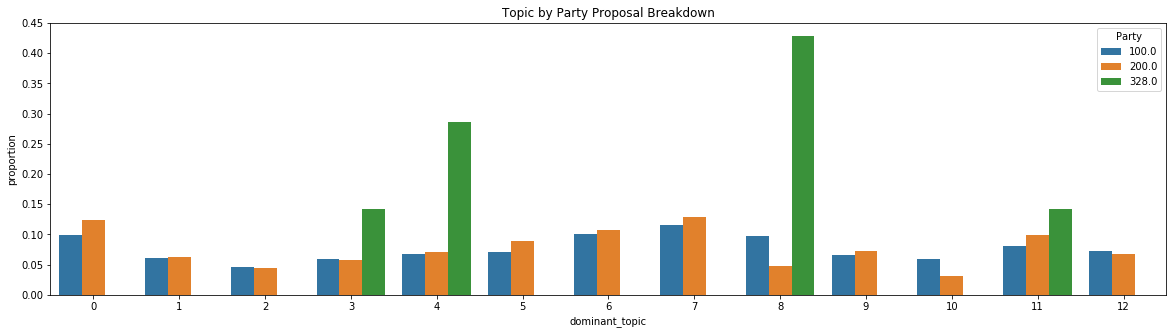

In [162]:
#Looking at dominant topic contribution by topic and party
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x3, y3, hue = "dominant_topic", "proportion", "Party"
hue_order = ["1", "0"]
data=test

(test[x3]
 .groupby(test[hue])
 .value_counts(normalize=True)
 .rename(y3)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x3, y=y3, hue=hue).set_title('Topic by Party Proposal Breakdown'))


Text(0.5, 1.0, 'Topic by Percent Contribution to Passage')

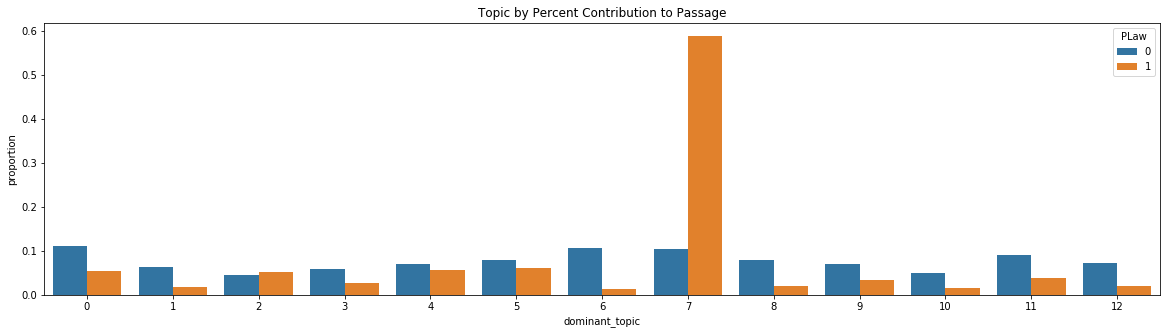

In [163]:
#Looking at dominant topic contribution by proportion
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x2, y2, hue = "dominant_topic", "proportion", "PLaw"
hue_order = ["1", "0"]
data=test

(test[x2]
 .groupby(test[hue])
 .value_counts(normalize=True)
 .rename(y2)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x2, y=y2, hue=hue).set_title('Topic by Percent Contribution to Passage'))


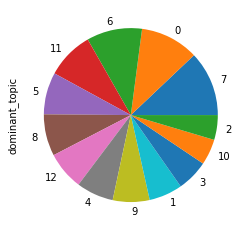

In [164]:
test['dominant_topic'].value_counts().plot.pie()

In [165]:
df_document_topic['dominant_topic'].value_counts()

7     6168
0     5544
6     5266
11    4495
5     3991
8     3962
12    3632
4     3530
9     3493
1     3180
3     3004
10    2452
2     2350
Name: dominant_topic, dtype: int64

In [166]:
print(df.shape)
print(df_document_topic.shape)

(51067, 30)
(51067, 14)


**Dominant topic visualizations**



In [167]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, transformed, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'topic_model_visualization.html')
panel

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      -28.370157   75.716713       1        1  10.495467
6      140.525131  125.038422       2        1   9.997081
8      -15.713381   -6.499068       3        1   9.028742
12     -34.624741  168.429764       4        1   8.794859
5       66.229309    7.804511       5        1   8.688814
11      54.002045   90.614914       6        1   8.472334
4     -115.580109  108.730423       7        1   7.601226
9      156.040054   31.690395       8        1   7.493485
1       31.304781  -90.663383       9        1   6.732285
3      125.523102  -64.160110      10        1   6.379376
7     -110.481079   11.011040      11        1   5.795032
10      58.766029  183.607056      12        1   5.455210
2      -69.457687  -81.489365      13        1   5.066089, topic_info=     Category          Freq           Term         Total  loglift  logprob
4096  Default  15425.000000         health  15425.000000  30.0000  30.0000
2821  Default   9077.000000           duty   9077.000000  29.0000  29.0000
7831  Default   9809.000000        revenue   9809.000000  28.0000  28.0000
8956  Default   9718.000000            tax   9718.000000  27.0000  27.0000
4721  Default   9399.000000       internal   9399.000000  26.0000  26.0000
8140  Default  12139.000000       security  12139.000000  25.0000  25.0000
7150  Default  18663.000000        program  18663.000000  24.0000  24.0000
8434  Default   6132.000000         social   6132.000000  23.0000  23.0000
1620  Default  14559.000000           code  14559.000000  22.0000  22.0000
2878  Default   8269.000000      education   8269.000000  21.0000  21.0000
3029  Default   6691.000000         energy   6691.000000  20.0000  20.0000
1274  Default   7732.000000           care   7732.000000  19.0000  19.0000
9009  Default   4641.000000    temporarily   4641.000000  18.0000  18.0000
2104  Default   6742.000000         credit   6742.000000  17.0000  17.0000
5026  Default   5158.000000           land   5158.000000  16.0000  16.0000
5528  Default   4543.000000       medicare   4543.000000  15.0000  15.0000
5511  Default   5069.000000        measure   5069.000000  14.0000  14.0000
8073  Default   4269.000000         school   4269.000000  13.0000  13.0000
8063  Default   4302.000000       schedule   4302.000000  12.0000  12.0000
8873  Default   4130.000000        suspend   4130.000000  11.0000  11.0000
8951  Default   3988.000000         tariff   3988.000000  10.0000  10.0000
9138  Default  10881.000000          title  10881.000000   9.0000   9.0000
9639  Default   5591.000000        veteran   5591.000000   8.0000   8.0000
5552  Default   4983.000000         member   4983.000000   7.0000   7.0000
8222  Default  17678.000000        service  17678.000000   6.0000   6.0000
4062  Default   3799.000000     harmonized   3799.000000   5.0000   5.0000
3300  Default   7123.000000         extend   7123.000000   4.0000   4.0000
1154  Default   5457.000000       business   5457.000000   3.0000   3.0000
8813  Default   3500.000000        summary   3500.000000   2.0000   2.0000
9782  Default   3989.000000          water   3989.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
1572  Topic13    259.086441         clinic    340.293017   2.7100  -5.9012
2387  Topic13   3022.951543     department   6307.259421   2.2471  -3.4444
9639  Topic13   2692.827449        veteran   5591.309192   2.2520  -3.5600
1453  Topic13   2187.793481          child   4859.363921   2.1846  -3.7677
1274  Topic13   3155.740415           care   7732.289313   2.0864  -3.4014
9818  Topic13    218.603760        welfare    305.767447   2.6470  -6.0711
8067  Topic13    174.086562          schip    244.925027   2.6412  -6.2988
3342  Topic13   1486.069936       facility   4231.003384   1.9363  -4.1545
9776  Topic13    350.896138          waste    622.331376   2.4096  -5.5979
2375  Topic1

In [92]:
filename3 = 'finalized_pyDavis_graph.sav'
pickle.dump(panel, open(filename3, 'wb'))
 

**Visualization using SVD and Kmeans**

In [173]:
# Construct the k-means clusters
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=13, random_state=2).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.26  0.12  0.09  0.09  0.14  0.18  0.22  0.84  0.16  0.14  0.08  0.2
   0.13]
 [-0.4  -0.16 -0.09 -0.13 -0.19 -0.24 -0.47  0.54 -0.26 -0.18 -0.11 -0.18
  -0.21]]
Perc of Variance Explained: 
 [0.07 0.11]


Text(0.5, 1.0, 'Congressional Bill Topic Clusters')

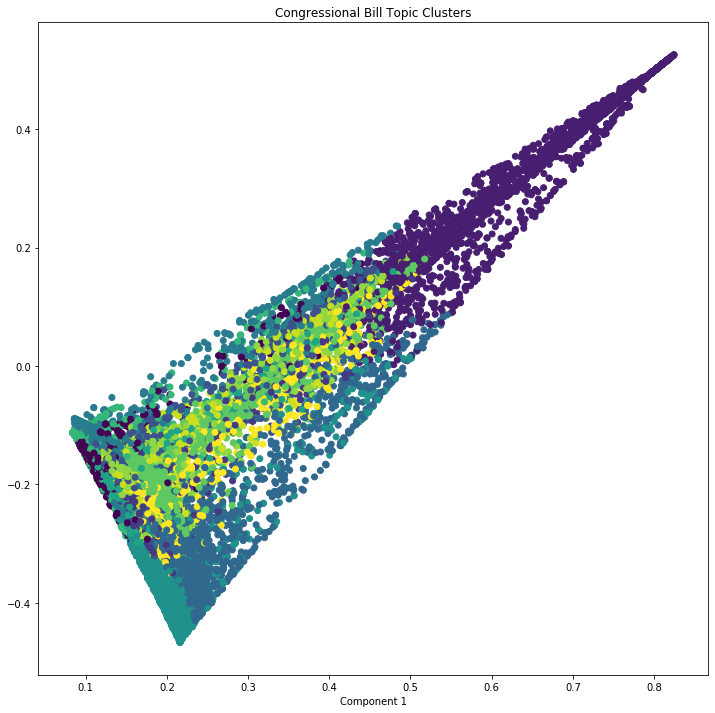

In [175]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Congressional Bill Topic Clusters", )

# **t-SNE**

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init=’pca’)
# 13-D -> 2-D
tsne_lda = tsne_model.fit_transform(doc_topic) # doc_topic is document-topic matrix from LDA or GuidedLDA 

In [176]:
from sklearn.manifold import TSNE
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lda_output)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 51067 samples in 0.105s...
[t-SNE] Computed neighbors for 51067 samples in 40.784s...
[t-SNE] Computed conditional probabilities for sample 1000 / 51067
[t-SNE] Computed conditional probabilities for sample 2000 / 51067
[t-SNE] Computed conditional probabilities for sample 3000 / 51067
[t-SNE] Computed conditional probabilities for sample 4000 / 51067
[t-SNE] Computed conditional probabilities for sample 5000 / 51067
[t-SNE] Computed conditional probabilities for sample 6000 / 51067
[t-SNE] Computed conditional probabilities for sample 7000 / 51067
[t-SNE] Computed conditional probabilities for sample 8000 / 51067
[t-SNE] Computed conditional probabilities for sample 9000 / 51067
[t-SNE] Computed conditional probabilities for sample 10000 / 51067
[t-SNE] Computed conditional probabilities for sample 11000 / 51067
[t-SNE] Computed conditional probabilities for sample 12000 / 51067
[t-SNE] Computed conditional probabilities for s

In [177]:
# hm = np.array([[y for (x,y) in best_lda_model[transformed.shape[i]]] for i in range(len(transformed.shape))])

In [179]:
tsne = TSNE(random_state=2017, perplexity=30, early_exaggeration=120)
embedding = tsne.fit_transform(lda_output)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = embedding.argmax(axis=1)

AttributeError: 'DataFrame' object has no attribute 'argmax'

In [ ]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = [all_palettes['Set1'][8][i] for i in embedding.hue],
            title = df.title,
            year = df.year,
            alpha = [0.9] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Papers')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.change.emit();
    """)

slider = Slider(start=df.year.min(), end=df.year.max(), value=2016, step=1, title="Before year")
slider.js_on_change('value', callback)

layout = column(slider, plot_tsne)
show(layout)

In [68]:
# N = 10000
# df_subset = df.loc[rndperm[:N],:].copy()
# data_subset = df_subset[feat_cols].values

In [69]:
# lda_output['tsne-2d-one'] = tsne_results[:,0]
# lda_output['tsne-2d-two'] = tsne_results[:,1]

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=df_subset,
#     legend="full",
#     alpha=0.3
# )

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Adding topics to MySQL:

Create a separate table for topics and link with BillID Primary Key

https://stackoverflow.com/questions/53518217/adding-topic-distribution-outcome-of-topic-model-to-pandas-dataframe

In [57]:
#make sure it is the right shape first!
test.shape

(51067, 44)

In [58]:
test.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,...,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,...,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,...,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,...,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,...,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


In [59]:
test2 = test.drop(columns=['IntrDate', 'PLawNum', 'PLawDate'])


In [60]:
test2.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Postal,PassH,PassS,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,0.11,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,...,MS,1,1,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,0.03,0.03,0.03,0.03,0.35,0.03,0.03,0.03,0.03,0.03,...,CA,0,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,0.00,0.00,0.00,0.00,0.40,0.03,0.04,0.00,0.17,0.00,...,CA,0,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,...,DC,0,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,0.00,0.00,0.00,0.08,0.00,0.66,0.20,0.00,0.00,0.00,...,SC,0,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


In [61]:
final_topics = test2.to_dict(orient = 'records')
final_topics[0]

{'Topic0': 0.11,
 'Topic1': 0.0,
 'Topic2': 0.0,
 'Topic3': 0.0,
 'Topic4': 0.0,
 'Topic5': 0.84,
 'Topic6': 0.0,
 'Topic7': 0.0,
 'Topic8': 0.0,
 'Topic9': 0.0,
 'Topic10': 0.0,
 'Topic11': 0.0,
 'Topic12': 0.0,
 'dominant_topic': 5,
 'BillID': '110-HR-1',
 'BillType': 'hr',
 'Chamber': 0,
 'Cong': 110,
 'Cosponsr': 205.0,
 'Mult': 1,
 'PLaw': 1,
 'Title': 'To provide for the implementation of the recommendations of the National Commission on Terrorist Attacks Upon the United States.',
 'Veto': 0,
 'Class': 0.0,
 'District': 2.0,
 'FrstConH': 0.0,
 'FrstConS': 0.0,
 'Gender': 0,
 'MRef': 1,
 'NameFull': 'Bennie Thompson',
 'Party': 100.0,
 'Postal': 'MS',
 'PassH': 1,
 'PassS': 1,
 'ImpBill': 1,
 'Majority': 1,
 'Major': 16.0,
 'Minor': 1615.0,
 'URL': 'https://www.congress.gov/bill/110th-congress/house-bill/1',
 'Summary': 'Implementing Recommendations of the 9/11 Commission Act of 2007 - Provides for implementation of recommendations of the National Commission on Terrorist Attacks U

In [62]:
from schema import DbSchema

bills_db = DbSchema(config_final)


In [63]:
# query = db.insert(bills_db.topics_table)
# bills_db.connection.execute(query, final_topics)